# IN-STK-5000 Project: Credit risk for mortgages - part 1
## Deadline 1: September 18
## Luca Attanasio, ...



### You can execute the code by running the cell below. 
Some changes were made to `TestLending.py` in order to collect all the utilities from each of the bankers and use boxplots to plot the utility values. Boxplots are not the best idea to plot the utility values since they can be misleading (on different tests one banker may outperform another and viceversa in other situations), but we can feel how well the banker is doing.
# WARNING: The code runs really slow with n_tests=100 (so we set the value to n_tests=2 here). For n_tests=100 look at the results below

Using TensorFlow backend.


-- Running banker: random
random granted loans 96.0
random granted loans 98.0
utility per tests on random decision maker, avg 644160, std 68906 
-- Running banker: forest
Testing accuracy of the classifier :  0.75
forest granted loans 193.0
Testing accuracy of the classifier :  0.76
forest granted loans 191.0
utility per tests with random forest, avg 1377500, std 33277
-- Running banker: nn
(800, 48) (800,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Epoch 1/7
800/800 [==============================] - 0s 483us/step - loss: 4.5932 - acc: 0.6412
Epoch 2/7
800/800 [==============================] - 0s 63us/step - loss: 3.7474 - acc: 0.6737
Epoch 3/7
800/800 [==============================] - 0s 64us/step - loss: 2.9440 - acc: 0.5575
Epoch 4/7
800/800 [==============================] - 0s 66us/step - loss: 4.5362 - acc: 0.6850
Epoch 5/7
800/800 [==============================] - 0s 61us/step - loss: 4.8710 - acc: 

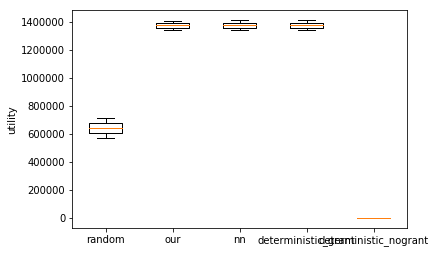

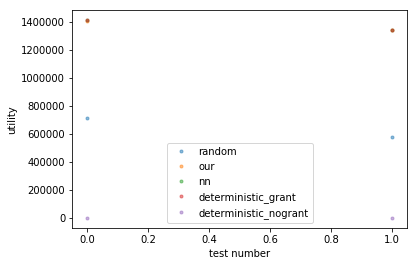

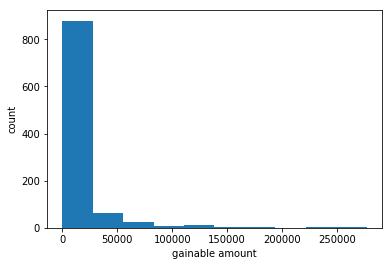

In [5]:
%matplotlib inline
%run TestLending.py 2
None

### Boxplots for 100 tests: utility vs strategy
The boxplots show the mean, and variance of the resulting utility for each banker.

<img src="100_tests.png" width="300px">

In this project, we use five bankers to collect data. In particular:
1. deterministic banker: always grant
2. deterministic banker: never grant
3. random banker
4. random forest banker
5. neural network banker (not optimized)

First of all, let's comment on the results obtained and then see the practical implementation. 

The worst performances are obtained if we always don't grant the loan. This behaviour is expected since the expected utility is always 0 and we have a high interest rate per month: $5\%$. We are aware that having a much lower interest rate may change the results (e.g. having $0.5\%$ per month), in that case the best option is probably this one since if we have a classifier with a $70\%$ accuracy, then if we grant a loan which won't be repaid we loose much more than what we can gain from all the other loans.

The second worst performances are those of the random classifier. Randomly choosing to grant or not a loan is not a good idea because we don't take into consideration any data from the input user. On average, half the loans are granted and half are not, but we don't make any assumption on which can be good and which can be bad.

The deterministic banker that always grants the loan has surprisingly good performances compared to the random forest banker and the neural network banker. Always granting the loan seems to be a good option, since we will always gain money if the users can pay it back. On this dataset, many users can pay back the loan and this option would increase our gain.

The random forest banker has great performances, it would probably outperform the always grant classifier if it had a much higher accuracy. The random forest banker is almost always granting the loan and not granting the loan just in rare cases. This is because the classifier isn't super-accurate ($75\%$ on average on the test set) and the utility function prefers to give the loan even if the classifier tends to avoid giving it (have a look in the code below). This behaviour is the preferred choice, since the utility is higher compared to relying purely on the classifier.

The neural network banker can still be improved, not much time was used to develop its model but it can surely be optimized to get the same results or better than the random forest.

To improve the accuracy of both the random forest and neural network, the MinMaxScaler was used, in order to rescale the features.

### 1. and 2. deterministic banker
The determinisc_banker can be initialized with an action that can be either 0 or 1, respectively the never grant and always grant bankers. Consequently, the action it always chooses is either 0 or 1 respectively.

In [ ]:
# %load deterministic_banker
import numpy as np

class DeterministicBanker:

    """
    Initialize banker with a given action: 0 don't grant, 1 grant the loan
    """
    def __init__(self, action):
        self.name = 'deterministic'
        self.action = action

    def fit(self, X, y):
        pass

    def set_interest_rate(self, rate):
        self.rate = rate

    def predict_proba(self, x):
        return 0


    def expected_utility(self, x, action):
        print("Expected utility: Not implemented")


    """
    Always grant or not grant the loan
    """
    def get_best_action(self, x):
        return self.action


### 3. random banker
The random banker returns a random action between 0 and 1. It may randomly go well, but it is the worst strategy to choose if we want to maximize the total utility.

In [ ]:
# %load random_banker.py
import numpy as np

class RandomBanker:

    def __init__(self):
        self.name = 'random'

    def fit(self, X, y):
        self.data = [X, y]

    def set_interest_rate(self, rate):
        self.rate = rate
        # return

    def predict_proba(self, x):
        return 0

    def expected_utility(self, x, action):
        print("Expected utility: Not implemented")

    """
    The returned action is either to grant (1) or not the loan (0) randomly
    """
    def get_best_action(self, x):
        return np.random.choice(2,1)[0]


### Calculating the exected utility
Before getting into the code for the random forest and neural network banker we explain the methodology used to get the expected utility.

The probability $\mathbb{P}(\vec{x})$ of being a bad loan, output of the classifier for a given sample, is used to calculate the expected utility $\mathbb{U}$ of a sample. In particular the formula used to get the expected utility is the following in case we grant the loan:
\begin{equation}
    \mathbb{E}(U | A) = m \cdot (1 + r)^n \cdot (1 - \mathbb{P}(\vec{x})) - m \cdot \mathbb{P}(\vec{x})
\end{equation}
where $m$ is the amount of the loan, $r$ is the interest rate (per month), $n$ is the lending period (in months) and $A$ is the action of granting the loan.


If we don't grant the loan, then the expected utility is null, since we don't gain anything but we also don't risk to loose anything.
\begin{equation}
    \mathbb{E}(U | B) = 0
\end{equation}
where $B$ is the action of not granting the loan.

### Maximizing the expected utility
In order to evaluate the best action between granting or not granting the loan, we can take the maximum between the expected utility of granting and not granting the loan. The corresponding action is our result.
The value of
\begin{equation}
    \max{(\mathbb{E}(U | A), \mathbb{E}(U | B))} 
\end{equation}
is 0 if $\mathbb{E}(U | A) < 0$ and $\mathbb{E}(U | A)$ otherwise.
The most common action is to grant the loan, because usually
\begin{equation}
    m \cdot (1 + r)^n \cdot (1 - \mathbb{P}(\vec{x})) > m \cdot \mathbb{P}(\vec{x})
\end{equation}

##### Comment: Instead of maximizing the utility, another option would be to put a lower or upper threshold on the expected utility. This could avoid granting some loans where we are not sure of the outcome and avoid risking too much on users who require really high loans. We saw that putting a lower threshold on the utility doesn't change the results by much.

### 4. Random forest banker
This banker uses a random forest classifier to predict the probability that the given input is a bad loan.
To get the best performances out of the classifier, cross fold validation is used against each training set, to select the best value of max depth for the tree.

In [ ]:
# %load project_banker.py
import numpy as np
import pandas as pd
# model for fitting dataset
from sklearn.ensemble import RandomForestClassifier
# select best model
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

class ProjectBanker:

    def __init__(self):
        self.name = 'forest'
        # self.best_max_depth = None
        self.best_max_depth = 10

    def preprocessing(self, X, fit=False):
        X_temp = X.copy()
        # rescale_features = ['age', 'duration', 'amount']
        # X_some_features = X_temp[rescale_features]

        if fit:
            self.scaler = MinMaxScaler()
            X_some_features = self.scaler.fit_transform(X_temp)
        else:
            self.scaler.transform(X_temp)

        # X_temp[rescale_features] = X_some_features
        return X_temp

    # Fit the model to the data.  You can use any model you like to do
    # the fit, however you should be able to predict all class
    # probabilities
    """
    This function uses a random forest classifier to predict new probabilities
    """
    def fit(self, X, y):
        if self.best_max_depth == None:
            X_scaled = self.preprocessing(X)
        else:
            X_scaled = self.preprocessing(X,fit=True)

        self.clf = RandomForestClassifier(n_estimators=100, random_state=0, max_depth=self.best_max_depth) # storing classifier
        self.clf.fit(X_scaled, y)

    """
    Function invoked once to get the best max depth of the tree for
    the test set
    """
    def set_best_max_depth(self, X, y):
        if self.best_max_depth == None:
            X_scaled = self.preprocessing(X, fit=True)
            depths = range(5,20)
            untrained_models = [RandomForestClassifier(n_estimators=100, max_depth=d) for d in depths]
            fold_scores = [cross_val_score(estimator=m, X=X_scaled, y=y, cv=10) for m in untrained_models]
            mean_xv_scores = [s.mean() for s in fold_scores]
            self.best_max_depth = np.asarray(mean_xv_scores).argmax()

    """
    Function to test the accuracy of the classifier
    """
    def test_accuracy(self, X, y):
        X_scaled = self.preprocessing(X)
        return self.clf.score(X_scaled, y)

    # set the interest rate
    """
    This function stores the interest rate within the function
    """
    def set_interest_rate(self, rate):
        self.rate = rate
        return

    # Predict the probability of failure for a specific person with data x
    """
    This function predicts the probability of failure (being a bad loan),
    given the data to predict for. It is necessary to cast the input
    to numpy since it is a Series.
    In case of single sample we also need to reshape it.
    """
    def predict_proba(self, x):
        x_reshaped = np.reshape(x.to_numpy(), (1, -1))
        x_scaled = self.preprocessing(x_reshaped)
        prediction = self.clf.predict_proba(x_scaled)
        return prediction[0][1]

    # The expected utility of granting the loan or not. Here there are two actions:
    # action = 0 do not grant the loan
    # action = 1 grant the loan
    #
    # Make sure that you extract the length_of_loan from the
    # 2nd attribute of x. Then the return if the loan is paid off to you is
    # amount_of_loan*(1 + rate)^length_of_loan
    # The return if the loan is not paid off is -amount_of_loan.
    """
    This function calculates the expected utility.
    The expected utility if the action is to grant the loan is given by
    the formula:
    amount_of_loan*(1 + self.rate)^length_of_loan * (1-self.predict_proba(x)) +
    -amount_of_loan * self.predict_proba(x)
    The expected utility if the action is not to grant anything is: 0
    This is true because we don't loose or get anything.
    """
    def expected_utility(self, x, action):
        amount_of_loan = x['amount']
        length_of_loan = x['duration']
        if action == 1:
            proba = self.predict_proba(x)
            gain = amount_of_loan * (pow(1 + self.rate, length_of_loan)) * (1 - proba)
            loss = amount_of_loan * proba
            return gain - loss

        return 0

    # Return the best action. This is normally the one that maximises expected utility.
    # However, you are allowed to deviate from this if you can justify the reason.
    """
    This function returns the best action such that the expected utility is
    maximized
    """
    def get_best_action(self, x):
        ## better way to calculate utility that allows to defiate from max
        ## threshold may be set higher to avoid granting too many loans
        actions = [0, 1]
        utility_0 = self.expected_utility(x, actions[0])
        utility_1 = self.expected_utility(x, actions[1])
        # grant about accuracy/100*200 = 150 -> error estimate
        # most of the measures are below 20 000
        threshold = 500
        if utility_1 - utility_0 > threshold:
            return actions[1]
        return actions[0]


### 5. Neural network banker
This banker uses a neural network classifier to predict the probability that the given input is a bad loan.

In [ ]:
# %load nn_banker.py
import numpy as np
import pandas as pd
import numpy.random as npr
# model for fitting dataset
# implement a nn here with keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from sklearn.preprocessing import MinMaxScaler

# suppress warnings
import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)

class ProjectBanker:

    def __init__(self):
        self.name = 'nn'
        npr.seed(100)

    def preprocessing(self, X, fit=False):
        X_temp = X.copy()
        # rescale_features = ['age', 'duration', 'amount']
        # X_some_features = X_temp[rescale_features]

        if fit:
            self.scaler = MinMaxScaler()
            X_some_features = self.scaler.fit_transform(X_temp)
        else:
            self.scaler.transform(X_temp)

        # X_temp[rescale_features] = X_some_features
        return X_temp

    # Fit the model to the data.  You can use any model you like to do
    # the fit, however you should be able to predict all class
    # probabilities
    """
    This function uses a neural network classifier to predict new probabilities
    """
    def fit(self, X, y):
        print(X.shape, y.shape)
        y = y - 1
        X_scaled = self.preprocessing(X, fit=True)

        ## nn with keras
        self.model = Sequential([
            Dense(64, input_shape=(X.shape[1],)),
            Activation('relu'),
            Dense(32),
            Activation('relu'),
            Dense(16),
            Activation('relu'),
            Dense(1),
            Activation('sigmoid'),
        ])
        self.model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=['accuracy'])
        self.model.fit(X_scaled, y, epochs=7)

    def test_accuracy(self, X, y):
        y = y - 1
        X_scaled = self.preprocessing(X)
        test_loss, test_acc = self.model.evaluate(X_scaled, y)
        return test_acc

    # set the interest rate
    """
    This function stores the interest rate within the function
    """
    def set_interest_rate(self, rate):
        self.rate = rate
        return

    # Predict the probability of failure for a specific person with data x
    """
    This function predicts the probability of failure (being a bad loan),
    given the data to predict for. It is necessary to cast the input
    to numpy since it is a Series.
    In case of single sample we also need to reshape it.
    """
    def predict_proba(self, x):
        x_reshaped = np.reshape(x.to_numpy(), (1, -1))
        # preprocessing
        x_scaled = self.preprocessing(x_reshaped)
        prediction = self.model.predict(x_scaled)
        return prediction[0][0]

    # The expected utility of granting the loan or not. Here there are two actions:
    # action = 0 do not grant the loan
    # action = 1 grant the loan
    #
    # Make sure that you extract the length_of_loan from the
    # 2nd attribute of x. Then the return if the loan is paid off to you is
    # amount_of_loan*(1 + rate)^length_of_loan
    # The return if the loan is not paid off is -amount_of_loan.
    """
    This function calculates the expected utility.
    The expected utility if the action is to grant the loan is given by
    the formula:
    amount_of_loan * (pow(1 + self.rate, length_of_loan)) * (1 - self.predict_proba(x)) +
    -amount_of_loan * self.predict_proba(x)
    The expected utility if the action is not to grant anything is: 0
    This is true because we don't loose or get anything.
    """
    def expected_utility(self, x, action):
        amount_of_loan = x['amount']
        length_of_loan = x['duration']
        if action == 1:
            proba = self.predict_proba(x)
            gain = amount_of_loan * (pow(1 + self.rate, length_of_loan)) * (1 - proba)
            loss = amount_of_loan * proba
            return gain - loss

        return 0

    # Return the best action. This is normally the one that maximises expected utility.
    # However, you are allowed to deviate from this if you can justify the reason.
    """
    This function returns the best action such that the expected utility is
    maximized
    """
    def get_best_action(self, x):
        actions = [0, 1]
        utility_0 = self.expected_utility(x, actions[0])
        utility_1 = self.expected_utility(x, actions[1])
        threshold = 500
        if utility_1 - utility_0 > threshold:
            return actions[1]

        return actions[0]
